In [78]:
class NMF_Data(object):
	def __init__(self, dat_x, dat_y):
		self.dat_x = dat_x
		self.dat_y = dat_y
		self.nmf_features = []

	def create_nmf(self, test_size=500):
		x_train, x_test, y_train, y_test = train_test_split(self.dat_x, self.dat_y, random_state=1, test_size = test_size)
		print(x_train.shape, x_test.shape)
		
		nmf = NMF(n_components=300, random_state=0)
		nmf.fit(x_train)

		x_train_nmf = nmf.transform(x_train)
		x_test_nmf = nmf.transform(x_test)

		self.nmf_features.append(x_train_nmf)
		self.nmf_features.append(y_train)
		self.nmf_features.append(x_test_nmf)
		self.nmf_features.append(y_test)

	def get_nmf_features(self):
		return self.nmf_features

	def save_nmf(self, filename):
		self.create_nmf()
		np.save(filename, self.nmf_features)

### Simple emotion classification

In [79]:
import ipdb
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import optimizers
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
import warnings

warnings.filterwarnings('ignore')
my_data = np.genfromtxt('dense_data_type_and_emot.csv', delimiter=',')
my_data = my_data[:800,:] #select data
np.random.seed(0)
np.random.shuffle(my_data)	
features_init = my_data[:,1:]
features = features_init / features_init.max(axis=0)
labels = my_data[:,0:2] 
nmf_total = NMF_Data(features, labels)
nmf_total.create_nmf(test_size=150)
nmf_features = nmf_total.get_nmf_features()

x_train_nmf = nmf_features[0]
y_train_cat = nmf_features[1][:,0]   
y_train_emot1 = nmf_features[1][:,1]    
y_train_emot1 -= np.ones(len(y_train_emot1), dtype='int64') #tag

x_test_nmf = nmf_features [2]
y_test_cat = nmf_features[3][:,0]
y_test_emot1 = nmf_features[3][:,1]
y_test_emot1 -= np.ones(len(y_test_emot1), dtype='int64') #tag

(650, 3004) (150, 3004)


Train on 650 samples, validate on 150 samples
Epoch 1/100
650/650 [==============================] - 6s 10ms/step - loss: 2.7281 - acc: 0.1169 - val_loss: 2.5946 - val_acc: 0.1600
Epoch 2/100
650/650 [==============================] - 0s 55us/step - loss: 2.5201 - acc: 0.1708 - val_loss: 2.3982 - val_acc: 0.1600
Epoch 3/100
650/650 [==============================] - 0s 59us/step - loss: 2.3313 - acc: 0.1708 - val_loss: 2.2356 - val_acc: 0.1600
Epoch 4/100
650/650 [==============================] - 0s 55us/step - loss: 2.1817 - acc: 0.1708 - val_loss: 2.1021 - val_acc: 0.1600
Epoch 5/100
650/650 [==============================] - 0s 57us/step - loss: 2.0427 - acc: 0.1815 - val_loss: 1.9719 - val_acc: 0.1667
Epoch 6/100
650/650 [==============================] - 0s 56us/step - loss: 1.9297 - acc: 0.2723 - val_loss: 1.8839 - val_acc: 0.2400
Epoch 7/100
650/650 [==============================] - 0s 55us/step - loss: 1.8683 - acc: 0.2631 - val_loss: 1.8351 - val_acc: 0.2867
Epoch 8/100
650/

650/650 [==============================] - 0s 57us/step - loss: 0.2443 - acc: 0.9292 - val_loss: 0.4359 - val_acc: 0.8600
Epoch 62/100
650/650 [==============================] - 0s 56us/step - loss: 0.2185 - acc: 0.9477 - val_loss: 0.3958 - val_acc: 0.8800
Epoch 63/100
650/650 [==============================] - 0s 57us/step - loss: 0.2185 - acc: 0.9400 - val_loss: 0.3982 - val_acc: 0.8800
Epoch 64/100
650/650 [==============================] - 0s 58us/step - loss: 0.2159 - acc: 0.9338 - val_loss: 0.4037 - val_acc: 0.8467
Epoch 65/100
650/650 [==============================] - 0s 55us/step - loss: 0.2001 - acc: 0.9523 - val_loss: 0.4120 - val_acc: 0.8733
Epoch 66/100
650/650 [==============================] - 0s 56us/step - loss: 0.1993 - acc: 0.9446 - val_loss: 0.3858 - val_acc: 0.8800
Epoch 67/100
650/650 [==============================] - 0s 54us/step - loss: 0.2033 - acc: 0.9492 - val_loss: 0.3969 - val_acc: 0.8600
Epoch 68/100
650/650 [==============================] - 0s 56us/step

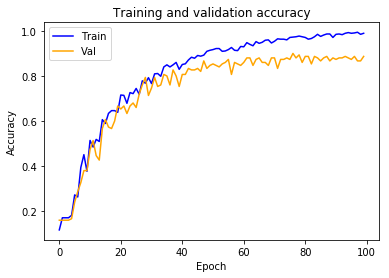

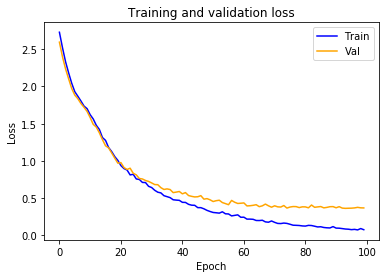

In [84]:
model = keras.Sequential([
	keras.layers.Dense(96, activation = tf.nn.leaky_relu),
	keras.layers.Dropout(0.4),
	keras.layers.Dense(64, activation = tf.nn.leaky_relu),
	keras.layers.Dropout(0.4),
	keras.layers.Dense(48, activation = tf.nn.leaky_relu),
	keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation = tf.nn.softmax) #output classification
])

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

history = model.fit(x_train_nmf, y_train_emot1, validation_data = (x_test_nmf,y_test_emot1), batch_size = 128,epochs = 100)
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
        

# Get the number of epochs
epochs = range(len(acc))

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, color='blue', label='Train')
plt.plot(epochs, val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, color='blue', label='Train')
plt.plot(epochs, val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Compound emotion classification

In [91]:
#from data_preprocess import FiducialDataProcess
import ipdb
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import optimizers
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
import warnings
#from nmf_feature_engineering import NMF_Data

warnings.filterwarnings('ignore')
my_data = np.genfromtxt('dense_data_type_and_emot.csv', delimiter=',')
my_data = my_data[800:2500,:] #select data
np.random.seed(0)
np.random.shuffle(my_data)	
features_init = my_data[:,1:]
features = features_init / features_init.max(axis=0)
labels = my_data[:,0:2] 
nmf_total = NMF_Data(features, labels)
nmf_total.create_nmf(test_size=350)
nmf_features = nmf_total.get_nmf_features()

x_train_nmf = nmf_features[0]
y_train_cat = nmf_features[1][:,0]   
y_train_emot1 = nmf_features[1][:,1]    
y_train_emot1 -= 7*np.ones(len(y_train_emot1), dtype='int64') #tag

x_test_nmf = nmf_features [2]
y_test_cat = nmf_features[3][:,0]
y_test_emot1 = nmf_features[3][:,1]
y_test_emot1 -= 7*np.ones(len(y_test_emot1), dtype='int64') #tag

#ipdb.set_trace()

(1350, 3004) (350, 3004)


Train on 1350 samples, validate on 350 samples
Epoch 1/100
1350/1350 [==============================] - 7s 6ms/step - loss: 2.7690 - acc: 0.0637 - val_loss: 2.7428 - val_acc: 0.0629
Epoch 2/100
1350/1350 [==============================] - 0s 50us/step - loss: 2.7295 - acc: 0.1326 - val_loss: 2.7189 - val_acc: 0.1457
Epoch 3/100
1350/1350 [==============================] - 0s 54us/step - loss: 2.6864 - acc: 0.1763 - val_loss: 2.6879 - val_acc: 0.1686
Epoch 4/100
1350/1350 [==============================] - 0s 51us/step - loss: 2.6297 - acc: 0.2296 - val_loss: 2.6284 - val_acc: 0.1857
Epoch 5/100
1350/1350 [==============================] - 0s 49us/step - loss: 2.5464 - acc: 0.2444 - val_loss: 2.5517 - val_acc: 0.2257
Epoch 6/100
1350/1350 [==============================] - 0s 48us/step - loss: 2.4384 - acc: 0.2889 - val_loss: 2.4365 - val_acc: 0.2486
Epoch 7/100
1350/1350 [==============================] - 0s 49us/step - loss: 2.2950 - acc: 0.3000 - val_loss: 2.3083 - val_acc: 0.2371
Ep

1350/1350 [==============================] - 0s 49us/step - loss: 0.6677 - acc: 0.7659 - val_loss: 1.2129 - val_acc: 0.5943
Epoch 61/100
1350/1350 [==============================] - 0s 53us/step - loss: 0.6448 - acc: 0.7763 - val_loss: 1.2144 - val_acc: 0.6000
Epoch 62/100
1350/1350 [==============================] - 0s 48us/step - loss: 0.6530 - acc: 0.7667 - val_loss: 1.2092 - val_acc: 0.6200
Epoch 63/100
1350/1350 [==============================] - 0s 48us/step - loss: 0.6359 - acc: 0.7756 - val_loss: 1.1977 - val_acc: 0.6171
Epoch 64/100
1350/1350 [==============================] - 0s 47us/step - loss: 0.6264 - acc: 0.7763 - val_loss: 1.2613 - val_acc: 0.5629
Epoch 65/100
1350/1350 [==============================] - 0s 49us/step - loss: 0.6382 - acc: 0.7689 - val_loss: 1.2502 - val_acc: 0.5829
Epoch 66/100
1350/1350 [==============================] - 0s 48us/step - loss: 0.6130 - acc: 0.7896 - val_loss: 1.2307 - val_acc: 0.5886
Epoch 67/100
1350/1350 [==============================

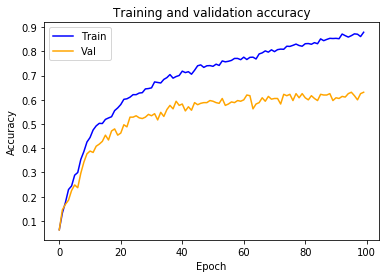

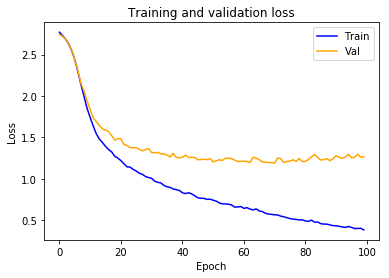

In [101]:
model = keras.Sequential([
	keras.layers.Dense(96, activation = tf.nn.leaky_relu),
	keras.layers.Dropout(0.4),
	keras.layers.Dense(64, activation = tf.nn.leaky_relu),
	keras.layers.Dropout(0.4),
	keras.layers.Dense(48, activation = tf.nn.leaky_relu),
	keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation = tf.nn.softmax) #output classification
])

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

history = model.fit(x_train_nmf, y_train_emot1, validation_data = (x_test_nmf,y_test_emot1), batch_size = 128,epochs = 100)
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
        

# Get the number of epochs
epochs = range(len(acc))

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, color='blue', label='Train')
plt.plot(epochs, val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, color='blue', label='Train')
plt.plot(epochs, val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()